In [1]:
import torch

In [2]:
%load_ext autoreload
%autoreload 2

from watermark_stable_diffusion import WatermarkStableDiffusion

In [3]:
model_id = "runwayml/stable-diffusion-v1-5"
pipe = WatermarkStableDiffusion.from_pretrained(model_id)
pipe = pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [23]:
prompt = "Cheese burger"
watermarking_mask = torch.zeros((1, 4, 64, 64))
image = pipe(prompt,
            watermarking_mask=watermarking_mask.bool().cuda(), # type: ignore
            watermarking_delta=1.0, 
            output_type='pil', 
            num_inference_steps=50).images[0] # type:ignore

  0%|          | 0/50 [00:00<?, ?it/s]

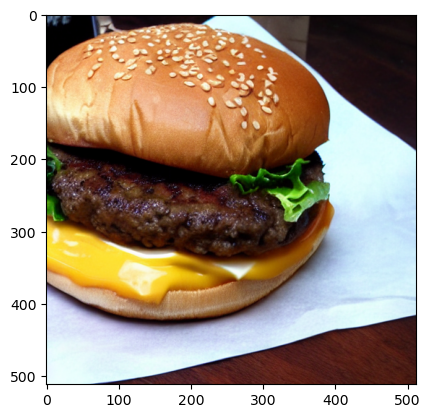

In [24]:
import matplotlib.pyplot as plt
import numpy as np

img_array = np.array(image)

plt.imshow(img_array)
plt.show()